<a href="https://colab.research.google.com/github/pedromonteiro18/HistologyDetectron/blob/main/Histology_Detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install detectron2

In [1]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
!pip install tqdm
from tqdm import tqdm
# opencv is pre-installed on colab

1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Run a pre-trained detectron2 model

We first download an image from the COCO dataset:

In [5]:
im = cv2.imread("/content/drive/My Drive/Colab Notebooks/Histology/sample tissue/s19.png")
# cv2_imshow(im)

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

In [6]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

/usr/local/lib/python3.6/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:124: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


In [7]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([], device='cuda:0', dtype=torch.int64)
Boxes(tensor([], device='cuda:0', size=(0, 4)))


In [8]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
# cv2_imshow(out.get_image()[:, :, ::-1])

# Train on a custom dataset

Register dataset

In [9]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/drive/My Drive/Colab Notebooks/Histology/Histology COCO/Histology.json", "/content/drive/My Drive/Colab Notebooks/Histology/Histology COCO/")
register_coco_instances("my_dataset_val", {}, "/content/drive/My Drive/Colab Notebooks/Histology/Histology COCO Test/Histology Test.json", "/content/drive/My Drive/Colab Notebooks/Histology/Histology COCO Test/Images")

In [10]:
register_coco_instances("my_dataset_train2", {}, "/content/drive/MyDrive/CellData/train/EvgTrain-8.json", "/content/drive/MyDrive/CellData/train")
register_coco_instances("my_dataset_val2", {}, "/content/drive/MyDrive/CellData/val/EvgVal-9.json", "/content/drive/MyDrive/CellData/val")

In [11]:
trainDict = DatasetCatalog.get("my_dataset_train")
testDict = DatasetCatalog.get("my_dataset_val")
trainDict2 = DatasetCatalog.get("my_dataset_train2")
testDict2 = DatasetCatalog.get("my_dataset_val2")

[02/04 00:11:07 d2.data.datasets.coco]: Loaded 4 images in COCO format from /content/drive/My Drive/Colab Notebooks/Histology/Histology COCO/Histology.json
[02/04 00:11:07 d2.data.datasets.coco]: Loaded 1 images in COCO format from /content/drive/My Drive/Colab Notebooks/Histology/Histology COCO Test/Histology Test.json
WARNING [02/04 00:11:08 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[02/04 00:11:08 d2.data.datasets.coco]: Loaded 49 images in COCO format from /content/drive/MyDrive/CellData/train/EvgTrain-8.json
WARNING [02/04 00:11:08 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[02/04 00:11:08 d2.data.datasets.coco]: Loaded 8 images in COCO format from /content/drive/MyDrive/CellData/val/EvgVal-9.json


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



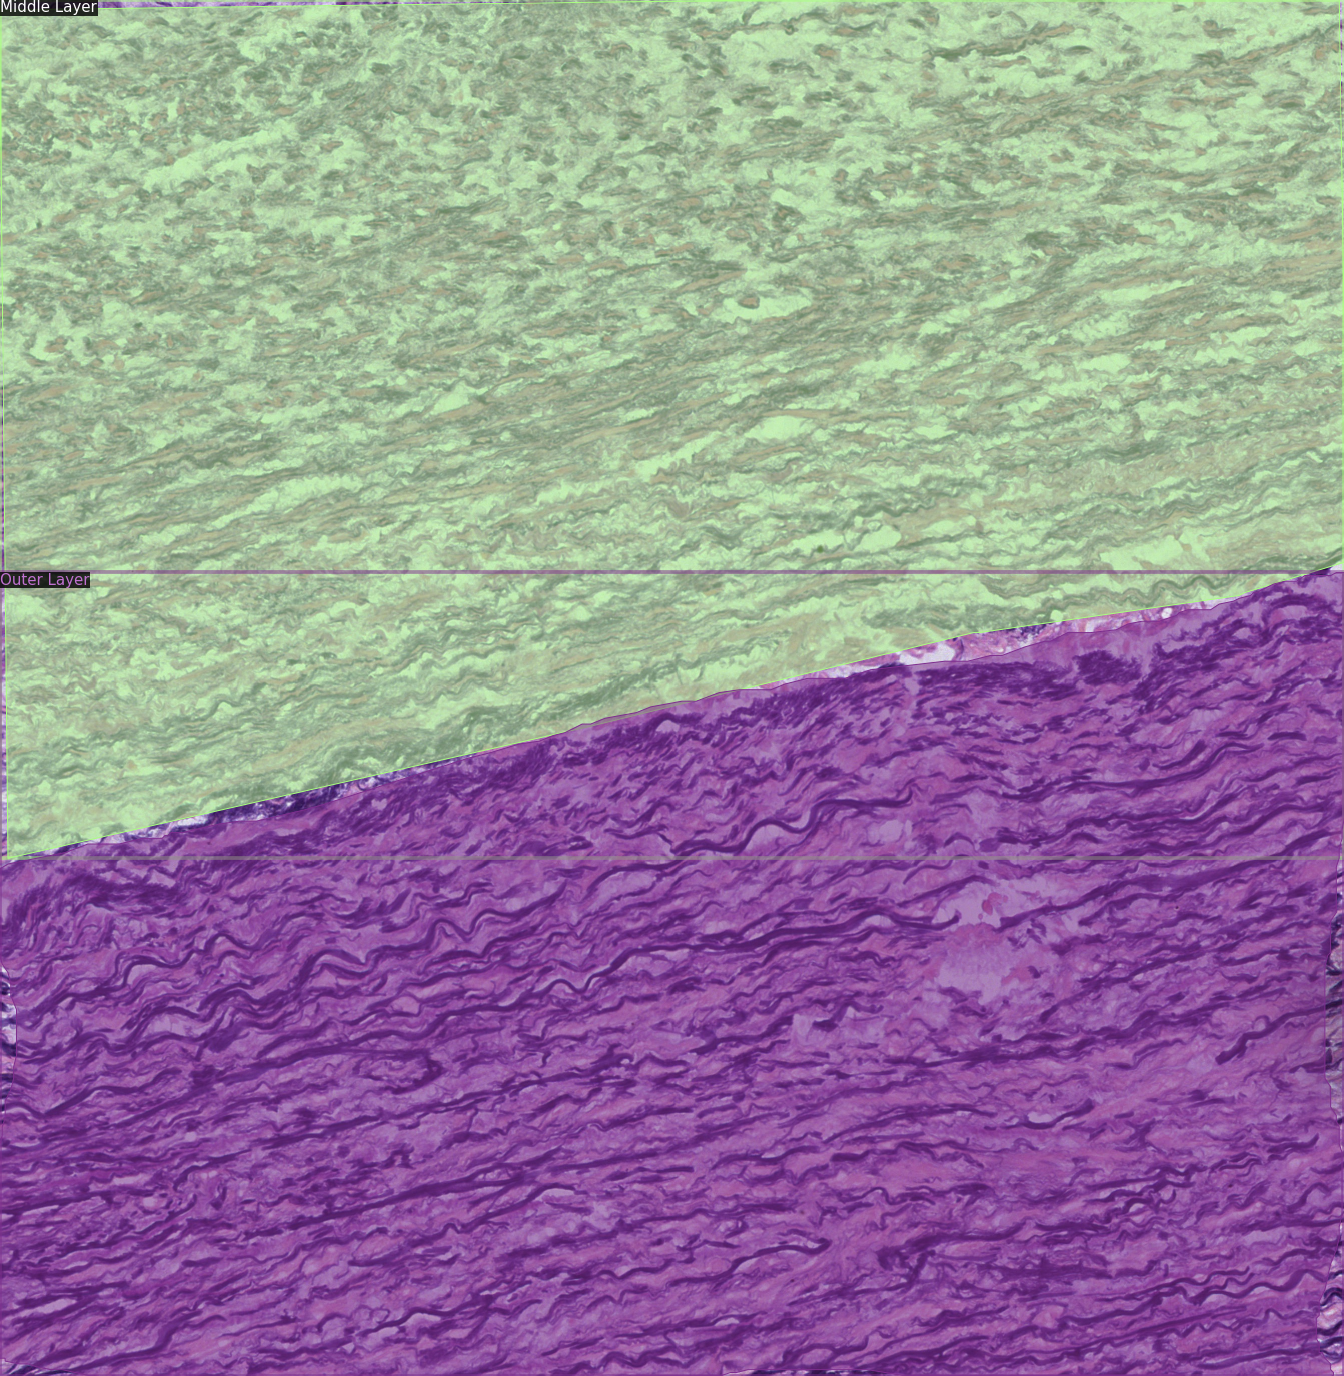

In [12]:
dataset_dicts = trainDict
histology_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts2 = trainDict2
histology_metadata2 = MetadataCatalog.get("my_dataset_train2")
for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=histology_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])


## Train!

Now, let's fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU, or ~2 minutes on a P100 GPU.


In [13]:
from detectron2.engine import DefaultTrainer

CUDA_LAUNCH_BLOCKING=1
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.0025  # learning rate
cfg.SOLVER.MAX_ITER = 300    # number of iterations
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 4   # faster, (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # number of classes

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
# trainer.train()

[02/04 00:11:10 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

In [14]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

Reusing TensorBoard on port 6006 (pid 805), started 0:22:01 ago. (Use '!kill 805' to kill it.)

<IPython.core.display.Javascript object>

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [15]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "/content/drive/MyDrive/Colab Notebooks/Histology/model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

Instances(num_instances=2, image_height=2752, image_width=2688, fields=[pred_boxes: Boxes(tensor([[1950.2708,  195.7163, 2675.9614, 2752.0000],
        [ 520.9059,   62.1055, 2529.5825, 2752.0000]], device='cuda:0')), scores: tensor([0.9462, 0.8528], device='cuda:0'), pred_classes: tensor([2, 1], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, F

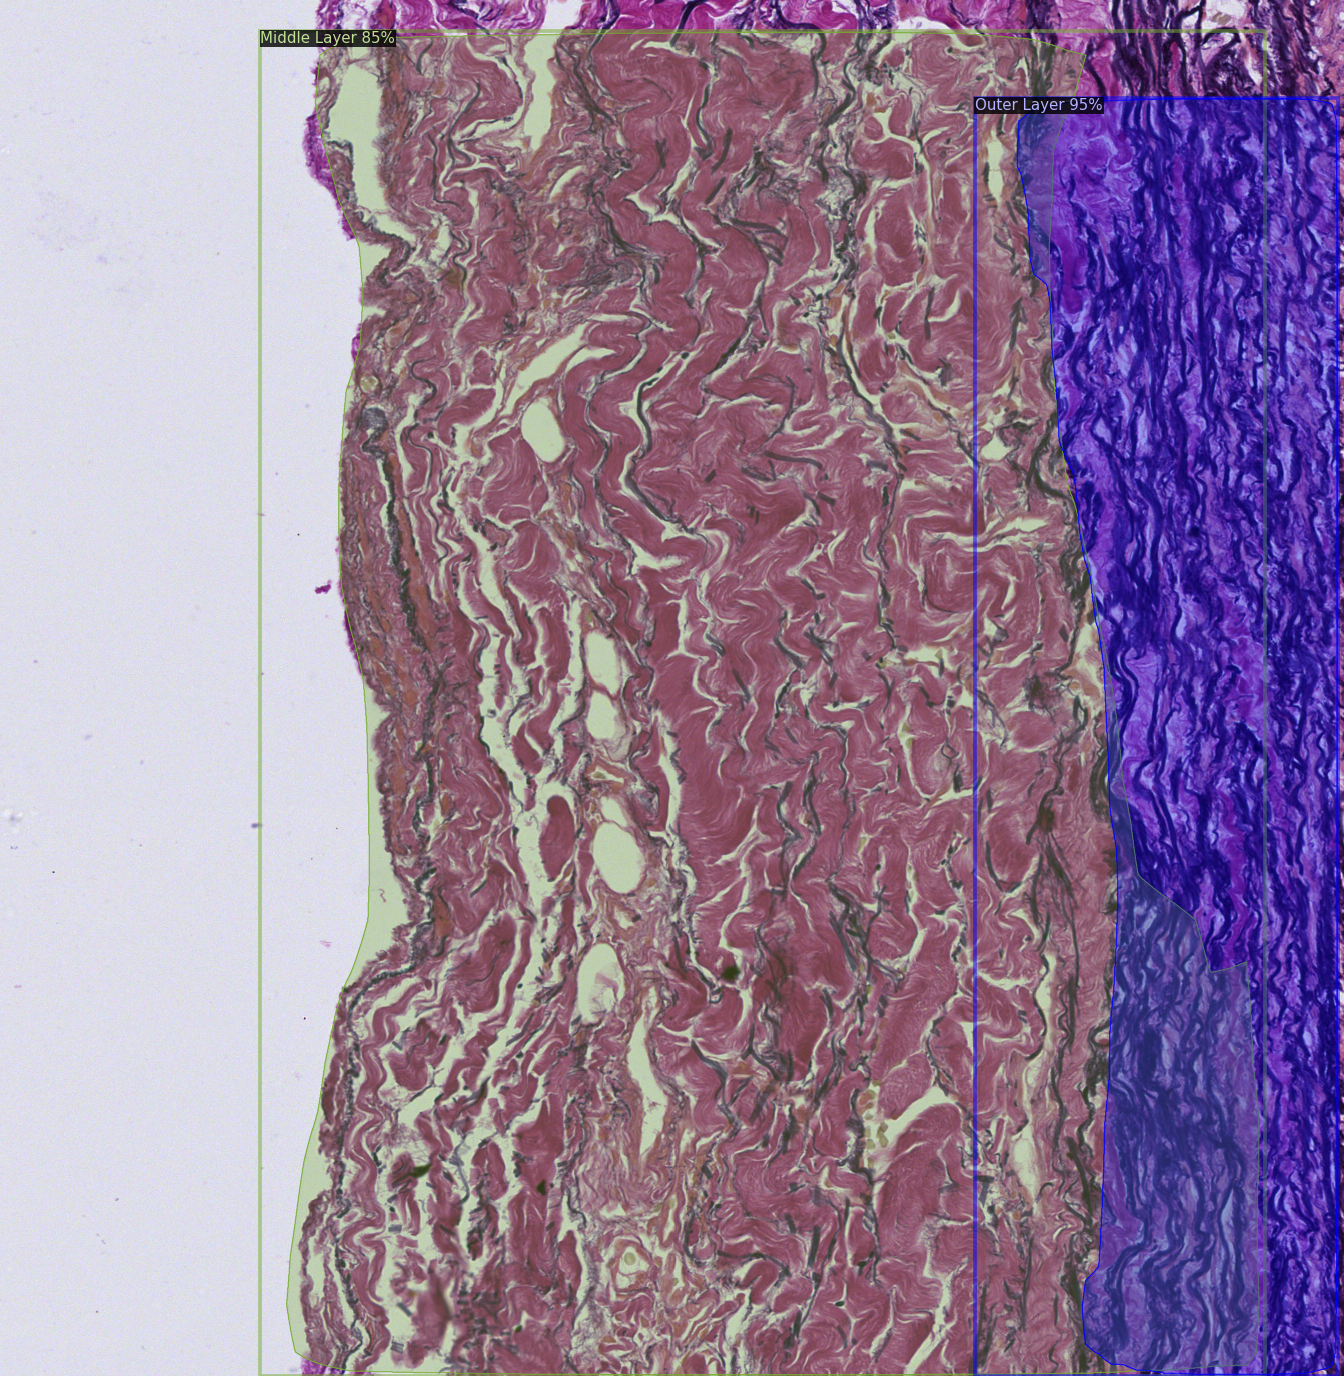

In [45]:
from detectron2.utils.visualizer import ColorMode
from detectron2.structures.masks import polygon_area
# !pip install tensorflow
import tensorflow as tf

# from detectron2.structures.masks import 

# dataset_dicts = get_balloon_dicts("balloon/val")
dataset_dicts = testDict
for d in random.sample(dataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    print(outputs["instances"])
    print(outputs["instances"].pred_masks)
    print(outputs["instances"].pred_classes)
    print(outputs["instances"].pred_boxes)
    confident_detections = outputs["instances"][outputs["instances"].scores > 0.9]
    print(confident_detections.pred_masks)
    # print('gt_masks' in outputs["instances"])

    print('mask...')
    mask = confident_detections.pred_masks
    print('flattening...')
    # mask_list = list(mask.flatten())
    # list_len = len(mask_list)
    # print("Tensor List Length: ", list_len)
    # print("Counting pixels...")
    # count = 0
    # for i in tqdm(list_len):
    #   if mask_list[i] == True:
    #     count += 1
    # print(count)
    print('Mask shape: ', mask.size())
    print('Total mask pixels: ', mask.size()[1]*mask.size()[2])
    with tf.compat.v1.Session() as sess:
      sumT = tf.math.count_nonzero(mask.cpu())
      truePixels = sess.run(sumT)

    print('True pixels: ', truePixels)
    print('Proportion of image that is the outer layer: ', 100*truePixels/(mask.size()[1]*mask.size()[2]),'%')
    # print('Image size: ', im[:, :, ::-1].shape())

    v = Visualizer(im[:, :, ::-1],
                   metadata=histology_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

We can also evaluate its performance using AP metric implemented in COCO API.

In [ ]:
# from detectron2.evaluation import COCOEvaluator, inference_on_dataset
# from detectron2.data import build_detection_test_loader
# evaluator = COCOEvaluator("balloon_val", ("bbox", "segm"), False, output_dir="./output/")
# val_loader = build_detection_test_loader(cfg, "balloon_val")
# print(inference_on_dataset(trainer.model, val_loader, evaluator))
# # another equivalent way to evaluate the model is to use `trainer.test`

# Other types of builtin models

In [ ]:
# # Inference with a panoptic segmentation model
# cfg = get_cfg()
# cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
# predictor = DefaultPredictor(cfg)
# panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
# v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
# out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
# cv2_imshow(out.get_image()[:, :, ::-1])